# Neural Network from Scratch using NumPy

This notebook implements a 2-layer feedforward neural network from scratch using only NumPy. The network is trained on the sklearn digits dataset to classify handwritten digits (0-9).

## Project Overview

- **Architecture**: 2-layer feedforward neural network
- **Input**: 64 features (8×8 grayscale images flattened)
- **Hidden Layer**: 32 neurons with ReLU activation
- **Output Layer**: 10 neurons with Softmax activation
- **Loss Function**: Cross-entropy loss
- **Optimizer**: Mini-batch gradient descent
- **Target Accuracy**: ~90%

## Key Learning Objectives

1. Understanding forward propagation
2. Implementing backpropagation from scratch
3. Working with activation functions (ReLU, Softmax)
4. Mini-batch gradient descent
5. Cross-entropy loss computation

## 1. Import Dependencies

We'll use NumPy for mathematical operations, sklearn for the dataset, and matplotlib for visualization.

In [56]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

## 2. Activation Functions and Loss Function

Let's implement the core mathematical functions needed for our neural network:

- **ReLU**: Rectified Linear Unit activation function
- **Softmax**: Converts logits to probability distribution
- **Cross-entropy**: Loss function for multi-class classification

In [57]:
def relu(x):
    """
    ReLU activation function.
    Applies the rectifier linear unit: f(x) = max(0, x).
    """
    return np.maximum(0, x)

def relu_derivative(x):
    """
    Derivative of the ReLU function.
    Returns 1 for positive inputs, 0 otherwise.
    """
    return (x > 0).astype(int)

def softmax(x):
    """
    Softmax activation function.
    Numerically stable implementation to prevent overflow.
    Applies the function exp(x_i) / sum(exp(x_j)) for all j.
    """
    # Subtract max for numerical stability
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / np.sum(e_x, axis=1, keepdims=True)

def cross_entropy_loss(y_true, y_pred):
    """
    Calculates the cross-entropy loss.
    y_true: One-hot encoded true labels.
    y_pred: Softmax probabilities from the output layer.
    """
    m = y_true.shape[0]
    # Small epsilon to avoid log(0)
    loss = -1/m * np.sum(y_true * np.log(y_pred + 1e-9))
    return loss

## 3. Neural Network Class

This is the core implementation of our neural network. The class includes:

- **Initialization**: Random weight initialization and zero bias initialization
- **Forward Pass**: Computing predictions through the network
- **Backward Pass**: Computing gradients using backpropagation
- **Parameter Updates**: Updating weights and biases using gradient descent
- **Prediction**: Making predictions on new data

In [58]:
class NeuralNetwork:
    """
    A simple 2-layer feedforward neural network.
    """
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.01):
        """
        Initializes the network with random weights and biases.

        Args:
            input_size (int): Number of features in the input (e.g., 64 for digits).
            hidden_size (int): Number of neurons in the hidden layer (e.g., 32).
            output_size (int): Number of output classes (e.g., 10 for digits).
            learning_rate (float): The step size for gradient descent.
        """
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.learning_rate = learning_rate

        # Initialize weights and biases with small random values
        # W1: (input_size, hidden_size)
        self.W1 = np.random.randn(self.input_size, self.hidden_size) * 0.01
        # b1: (1, hidden_size)
        self.b1 = np.zeros((1, self.hidden_size))
        # W2: (hidden_size, output_size)
        self.W2 = np.random.randn(self.hidden_size, self.output_size) * 0.01
        # b2: (1, output_size)
        self.b2 = np.zeros((1, self.output_size))

    def forward_pass(self, X):
        """
        Performs the forward propagation step.

        Args:
            X (np.array): Input data of shape (m, input_size).

        Returns:
            A tuple of (output, Z2, A1, Z1) where:
            - A2: Output of the output layer (Softmax probabilities).
            - Z2: Weighted sum of inputs to the output layer.
            - A1: Output of the hidden layer (ReLU activations).
            - Z1: Weighted sum of inputs to the hidden layer.
        """
        # Hidden Layer
        self.Z1 = np.dot(X, self.W1) + self.b1
        self.A1 = relu(self.Z1)

        # Output Layer
        self.Z2 = np.dot(self.A1, self.W2) + self.b2
        self.A2 = softmax(self.Z2)

        return self.A2, self.Z2, self.A1, self.Z1

    def backward_pass(self, X, y, A2, Z2, A1, Z1):
        """
        Performs backpropagation to compute gradients.

        Args:
            X (np.array): Input data.
            y (np.array): True labels (one-hot encoded).
            A2, Z2, A1, Z1: Intermediate values from the forward pass.

        Returns:
            A tuple of (dW1, db1, dW2, db2) with the gradients.
        """
        m = X.shape[0]

        # Backpropagation for the output layer
        dZ2 = A2 - y  # Derivative of loss w.r.t. Z2
        dW2 = (1/m) * np.dot(A1.T, dZ2)
        db2 = (1/m) * np.sum(dZ2, axis=0, keepdims=True)

        # Backpropagation for the hidden layer
        dA1 = np.dot(dZ2, self.W2.T)
        dZ1 = dA1 * relu_derivative(Z1) # Element-wise multiplication
        dW1 = (1/m) * np.dot(X.T, dZ1)
        db1 = (1/m) * np.sum(dZ1, axis=0, keepdims=True)

        return dW1, db1, dW2, db2

    def update_parameters(self, dW1, db1, dW2, db2):
        """
        Updates weights and biases using gradient descent.
        """
        self.W1 -= self.learning_rate * dW1
        self.b1 -= self.learning_rate * db1
        self.W2 -= self.learning_rate * dW2
        self.b2 -= self.learning_rate * db2

    def predict(self, X):
        """
        Predicts the class for a given input.
        """
        A2, _, _, _ = self.forward_pass(X)
        return np.argmax(A2, axis=1)

## 4. Data Loading and Preprocessing

We'll load the digits dataset, perform one-hot encoding on the labels, and split the data into training and testing sets.

In [59]:
# Load and preprocess the data
digits = load_digits()
X, y = digits.data, digits.target

print(f"Dataset shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"Number of classes: {len(np.unique(y))}")
print(f"Feature range: [{X.min():.2f}, {X.max():.2f}]")

# One-hot encode the labels
encoder = OneHotEncoder(sparse_output=False)
y_one_hot = encoder.fit_transform(y.reshape(-1, 1))

print(f"One-hot encoded labels shape: {y_one_hot.shape}")

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Dataset shape: (1797, 64)
Labels shape: (1797,)
Number of classes: 10
Feature range: [0.00, 16.00]
One-hot encoded labels shape: (1797, 10)
Training set: 1437 samples
Test set: 360 samples


## 5. Visualize Sample Data

Let's look at some sample digits to understand our data better.

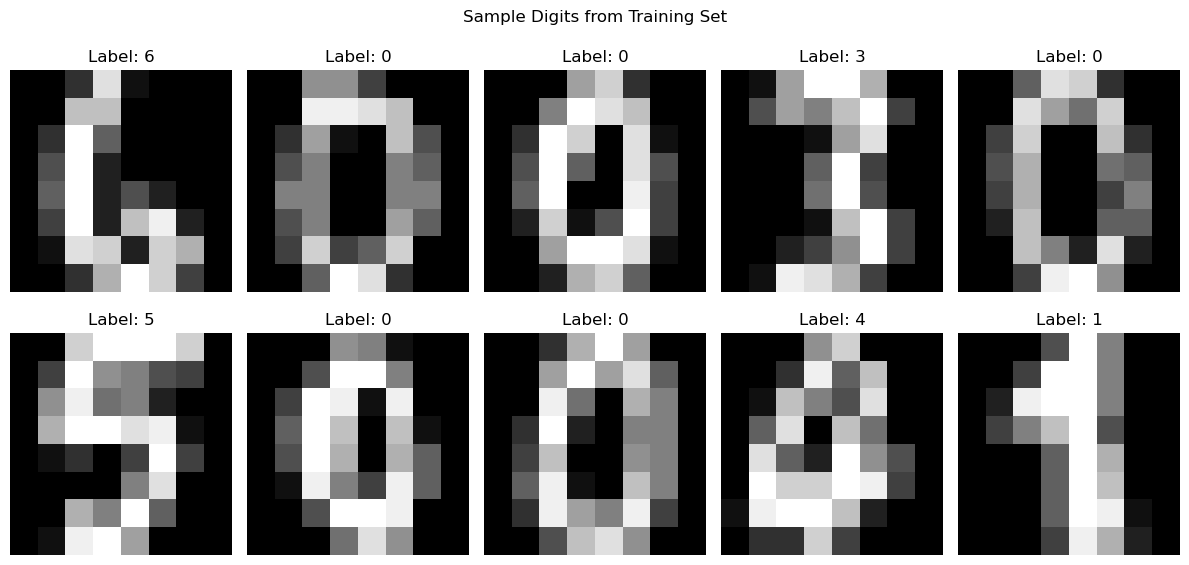

In [60]:
# Visualize some sample digits
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    # Reshape the flattened image back to 8x8
    image = X_train[i].reshape(8, 8)
    ax.imshow(image, cmap='gray')
    ax.set_title(f'Label: {np.argmax(y_train[i])}')
    ax.axis('off')

plt.suptitle('Sample Digits from Training Set')
plt.tight_layout()
plt.show()

## 6. Network Configuration and Training

Now we'll set up our network architecture and hyperparameters, then train the model.

In [61]:
# Define network architecture and hyperparameters
input_size = X_train.shape[1]  # 64 features
hidden_size = 32
output_size = y_train.shape[1] # 10 classes
learning_rate = 0.01
epochs = 1000
batch_size = 64

print("Network Architecture:")
print(f"Input Layer: {input_size} neurons")
print(f"Hidden Layer: {hidden_size} neurons (ReLU)")
print(f"Output Layer: {output_size} neurons (Softmax)")
print(f"Learning Rate: {learning_rate}")
print(f"Batch Size: {batch_size}")
print(f"Epochs: {epochs}")

Network Architecture:
Input Layer: 64 neurons
Hidden Layer: 32 neurons (ReLU)
Output Layer: 10 neurons (Softmax)
Learning Rate: 0.01
Batch Size: 64
Epochs: 1000


In [62]:
# Initialize the neural network
nn = NeuralNetwork(input_size, hidden_size, output_size, learning_rate)

# List to store loss history for plotting
loss_history = []

print(f"Starting training for {epochs} epochs...")

# Training loop
for epoch in range(epochs):
    # Shuffle the training data for each epoch
    permutation = np.random.permutation(X_train.shape[0])
    X_shuffled = X_train[permutation]
    y_shuffled = y_train[permutation]

    # Mini-batch gradient descent
    for i in range(0, X_shuffled.shape[0], batch_size):
        X_batch = X_shuffled[i:i + batch_size]
        y_batch = y_shuffled[i:i + batch_size]

        # Forward pass
        A2, Z2, A1, Z1 = nn.forward_pass(X_batch)

        # Backward pass (calculate gradients)
        dW1, db1, dW2, db2 = nn.backward_pass(X_batch, y_batch, A2, Z2, A1, Z1)

        # Update parameters
        nn.update_parameters(dW1, db1, dW2, db2)

    # Calculate and store loss for the entire training set
    A2_pred, _, _, _ = nn.forward_pass(X_train)
    loss = cross_entropy_loss(y_train, A2_pred)
    loss_history.append(loss)

    # Print progress every 100 epochs
    if (epoch + 1) % 100 == 0:
        predictions = np.argmax(A2_pred, axis=1)
        true_labels = np.argmax(y_train, axis=1)
        accuracy = np.mean(predictions == true_labels) * 100
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss:.4f}, Training Accuracy: {accuracy:.2f}%")

print("\nTraining complete!")

Starting training for 1000 epochs...
Epoch 100/1000, Loss: 0.0374, Training Accuracy: 99.30%
Epoch 200/1000, Loss: 0.0146, Training Accuracy: 99.86%
Epoch 300/1000, Loss: 0.0084, Training Accuracy: 100.00%
Epoch 400/1000, Loss: 0.0054, Training Accuracy: 100.00%
Epoch 500/1000, Loss: 0.0039, Training Accuracy: 100.00%
Epoch 600/1000, Loss: 0.0030, Training Accuracy: 100.00%
Epoch 700/1000, Loss: 0.0024, Training Accuracy: 100.00%
Epoch 800/1000, Loss: 0.0020, Training Accuracy: 100.00%
Epoch 900/1000, Loss: 0.0017, Training Accuracy: 100.00%
Epoch 1000/1000, Loss: 0.0015, Training Accuracy: 100.00%

Training complete!


## 7. Model Evaluation

Let's evaluate our trained model on the test set and analyze its performance.

Evaluating on the test set...
Final Test Accuracy: 96.67%

Detailed Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        33
           1       0.93      1.00      0.97        28
           2       0.97      1.00      0.99        33
           3       0.94      0.97      0.96        34
           4       1.00      0.98      0.99        46
           5       0.94      0.94      0.94        47
           6       0.97      0.97      0.97        35
           7       1.00      0.97      0.99        34
           8       0.97      0.93      0.95        30
           9       0.95      0.93      0.94        40

    accuracy                           0.97       360
   macro avg       0.97      0.97      0.97       360
weighted avg       0.97      0.97      0.97       360



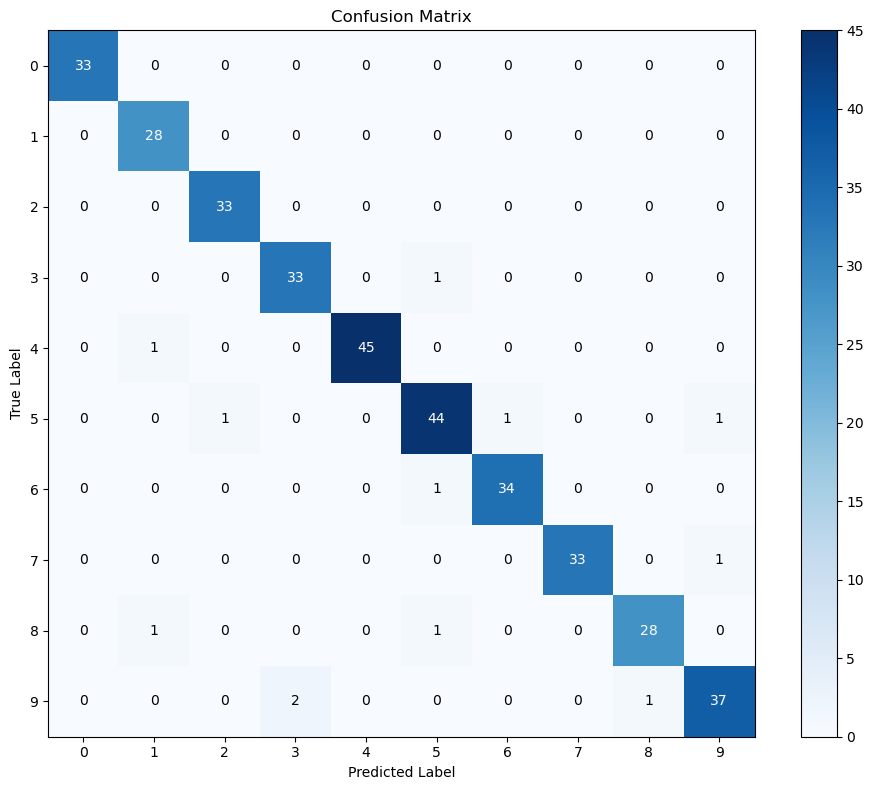

In [63]:
# Final evaluation on the test set
print("Evaluating on the test set...")
y_test_pred = nn.predict(X_test)
y_test_true = np.argmax(y_test, axis=1)
test_accuracy = np.mean(y_test_pred == y_test_true) * 100

print(f"Final Test Accuracy: {test_accuracy:.2f}%")

# Calculate accuracy per class
from sklearn.metrics import classification_report, confusion_matrix

print("\nDetailed Classification Report:")
print(classification_report(y_test_true, y_test_pred))

# Confusion Matrix
cm = confusion_matrix(y_test_true, y_test_pred)
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(10)
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add text annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

## 8. Training Loss Visualization

Let's visualize how the training loss decreased over epochs.

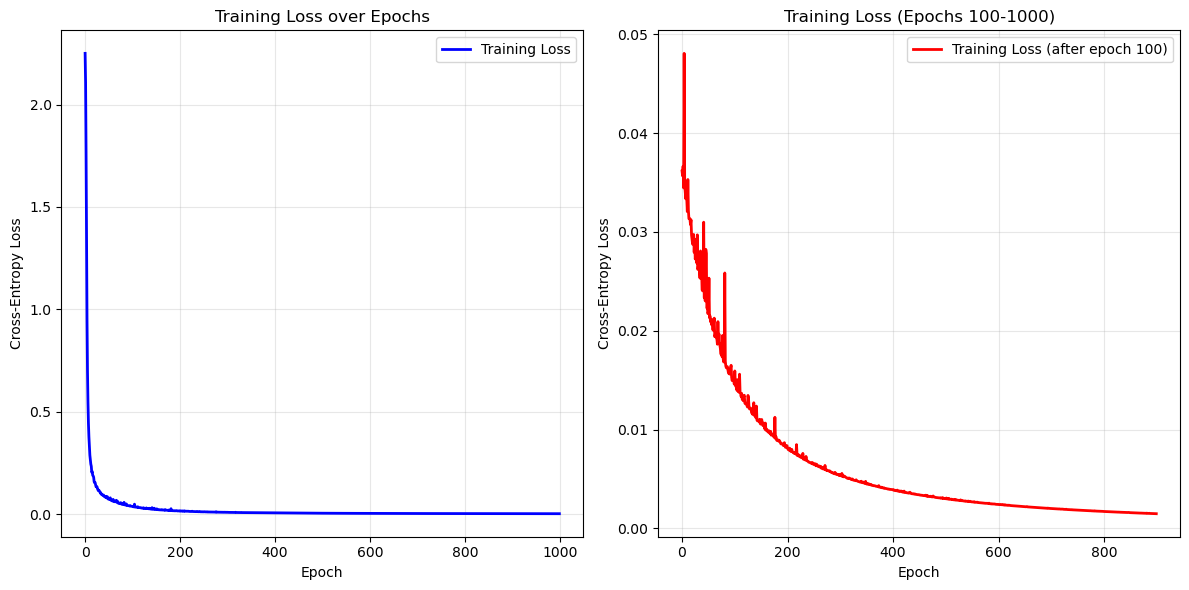

Initial Loss: 2.2504
Final Loss: 0.0015
Loss Reduction: 99.93%


In [64]:
# Visualization of Loss
plt.figure(figsize=(12, 6))

# Plot 1: Full training loss
plt.subplot(1, 2, 1)
plt.plot(loss_history, label='Training Loss', color='blue', linewidth=2)
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Loss after first 100 epochs (zoomed in)
plt.subplot(1, 2, 2)
plt.plot(loss_history[100:], label='Training Loss (after epoch 100)', color='red', linewidth=2)
plt.title('Training Loss (Epochs 100-1000)')
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Initial Loss: {loss_history[0]:.4f}")
print(f"Final Loss: {loss_history[-1]:.4f}")
print(f"Loss Reduction: {((loss_history[0] - loss_history[-1]) / loss_history[0] * 100):.2f}%")

## 9. Sample Predictions Visualization

Let's look at some sample predictions to see how well our model is performing.

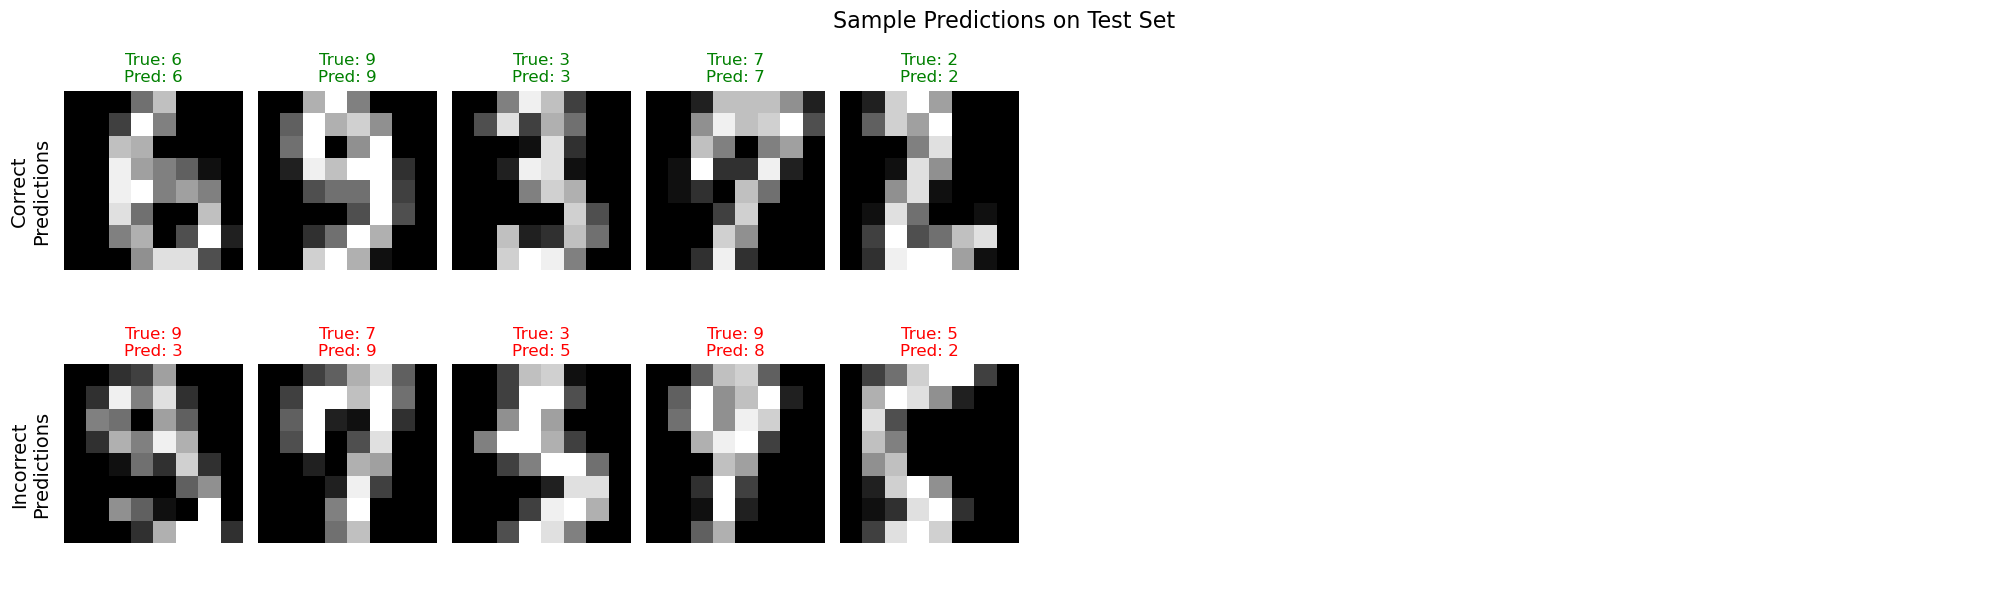

In [65]:
# Visualize some predictions
# Get predictions for test set
test_predictions = nn.predict(X_test)

# Find some correct and incorrect predictions
correct_mask = (test_predictions == y_test_true)
incorrect_mask = ~correct_mask

correct_indices = np.where(correct_mask)[0][:5]
incorrect_indices = np.where(incorrect_mask)[0][:5]

fig, axes = plt.subplots(2, 10, figsize=(20, 6))

# Show correct predictions
for i, idx in enumerate(correct_indices):
    image = X_test[idx].reshape(8, 8)
    axes[0, i].imshow(image, cmap='gray')
    axes[0, i].set_title(f'True: {y_test_true[idx]}\nPred: {test_predictions[idx]}', color='green')
    axes[0, i].axis('off')

# Show incorrect predictions
for i, idx in enumerate(incorrect_indices):
    image = X_test[idx].reshape(8, 8)
    axes[1, i].imshow(image, cmap='gray')
    axes[1, i].set_title(f'True: {y_test_true[idx]}\nPred: {test_predictions[idx]}', color='red')
    axes[1, i].axis('off')

# Hide unused subplots
for i in range(5, 10):
    axes[0, i].axis('off')
    axes[1, i].axis('off')

axes[0, 0].text(-2, 4, 'Correct\nPredictions', fontsize=14, ha='center', va='center', rotation=90)
axes[1, 0].text(-2, 4, 'Incorrect\nPredictions', fontsize=14, ha='center', va='center', rotation=90)

plt.suptitle('Sample Predictions on Test Set', fontsize=16)
plt.tight_layout()
plt.show()

## 10. Summary

In [66]:
# Final summary statistics
print("=" * 60)
print("NEURAL NETWORK TRAINING SUMMARY")
print("=" * 60)
print(f"Architecture: {input_size} → {hidden_size} → {output_size}")
print(f"Training Samples: {X_train.shape[0]}")
print(f"Test Samples: {X_test.shape[0]}")
print(f"Training Epochs: {epochs}")
print(f"Final Training Accuracy: {np.mean(np.argmax(nn.forward_pass(X_train)[0], axis=1) == np.argmax(y_train, axis=1)) * 100:.2f}%")
print(f"Final Test Accuracy: {test_accuracy:.2f}%")
print(f"Total Parameters: {nn.W1.size + nn.b1.size + nn.W2.size + nn.b2.size}")
print("=" * 60)

NEURAL NETWORK TRAINING SUMMARY
Architecture: 64 → 32 → 10
Training Samples: 1437
Test Samples: 360
Training Epochs: 1000
Final Training Accuracy: 100.00%
Final Test Accuracy: 96.67%
Total Parameters: 2410
